<a href="https://colab.research.google.com/github/pikanaeri/plm-model-comparison/blob/main/efam-performance/Modeling_Classifier_Performance_on_EFAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modeling Classifer Performance on EFAM
* This code can be run directly in the notebook.

In [ ]:
#@markdown Downloading Necessary Files
!gsutil cp gs://plm-model-comparison/EFAM_embed/Final_Super_Condensed_Annotations-updated_efam.tsv .
!gsutil cp gs://plm-model-comparison/EFAM_embed/efam_cluster_average_protein_length.csv .
!gsutil cp gs://plm-model-comparison/EFAM_embed/efam_phrog_e10.csv .
!gsutil cp gs://plm-model-comparison/EFAM_embed/PHROG_index.csv .

Copying gs://plm-model-comparison/EFAM_embed/Final_Super_Condensed_Annotations-updated_efam.tsv...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

/ [1 files][184.8 MiB/184.8 MiB]                                                
Operation completed over 1 objects/184.8 MiB.                                    
Copying gs://plm-model-comparison/EFAM_embed/efam_cluster_average_protein_length.csv...
- [1 files][  5.5 MiB/  5.5 MiB]                                                
Operation completed over 1 objects/5.5 MiB.                                      
Copying gs://plm-model-comparison/EFAM_embed/efam_phrog_e10.csv...
/ [1 files][ 10.4 MiB/ 10.4 MiB]                                                
Operation completed over 1 objects/10.4 MiB.                                     
Copying gs:/

In [ ]:
#@markdown Downloading sample cluster probabilities and predictions-make sure that these files align with your model
!gsutil cp gs://plm-model-comparison/EFAM_embed/Esm2/efam_clusters_all_probabilities.tsv .
!gsutil cp gs://plm-model-comparison/EFAM_embed/Esm2/efam_clusters_predictions.tsv .

In [ ]:
from tensorflow import keras
import pickle
from ast import literal_eval
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import textwrap

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

from scipy import interpolate
from itertools import cycle

phrog_palette = {
    'DNA, RNA and nucleotide metabolism': 'red',
    'connector': 'blue',
    'head and packaging': 'green',
    'integration and excision': 'pink',
    'lysis': 'gray',
    'moron, auxiliary metabolic gene and host takeover': 'brown',
    'other': 'purple',
    'tail': 'darkorange',
    'transcription regulation': 'cyan',
    'unknown': 'black'
}

#Creating HMM Predictions
efam_super_annote = pd.read_csv('Final_Super_Condensed_Annotations-updated_efam.tsv', sep='\t')
## convert 'Proteins' column read in as a string into a column of lists
efam_super_annote['Proteins'] = efam_super_annote['Proteins'].apply(literal_eval)

efam_super_annote = efam_super_annote.set_index(keys='Cluster')

efam_cluster_protein_lengths = pd.read_csv('efam_cluster_average_protein_length.csv', header=None, names=['Cluster', 'average_protein_length'])

efam_super_annote = efam_super_annote.merge(efam_cluster_protein_lengths, left_index=True, right_on='Cluster')
efam_super_annote = efam_super_annote.set_index(keys='Cluster')

efam_phrog_predicted = pd.read_csv('efam_phrog_e10.csv', index_col=0)
phrog_metadata = pd.read_csv('PHROG_index.csv')

cs = list(set(efam_phrog_predicted['cluster']))
efam_phrog_annotated = efam_super_annote[efam_super_annote.index.isin(cs)]

print(efam_super_annote.columns)

lb = {}
for c in tqdm(cs):
    ps = efam_phrog_predicted[efam_phrog_predicted['cluster'] == c]['phrog#']
    l = list(phrog_metadata[phrog_metadata['#phrog'].isin(ps)]['Category'])
    u, ind = np.unique(l, return_index=True)
    q = u[np.argsort(ind)]
    if q[0] == 'unknown function':
        if len(q) < 2:
            continue
        else:
            lb[c] = q
    else:
        lb[c] = q

## load all efam cluster predictions
efam_cluster_probs = pd.read_csv('efam_clusters_all_probabilities.tsv', sep='\t', index_col=0)
efam_cluster_probs_np = efam_cluster_probs.to_numpy()

phrog_classes = list(efam_cluster_probs.columns)

# convert the labels from integers to vectors
label_binarizer = LabelBinarizer()
label_binarizer.fit(phrog_classes)
preds = []
efamY = []
for c in tqdm(lb.keys()):
    if c not in efam_cluster_probs.index:
        print(c)
        continue
    truth = lb[c]
    if truth[0] == 'unknown function':
        if len(truth) == 1:
            efamY.append('unknown')
        else:
            efamY.append(truth[1])
    else:
        efamY.append(truth[0])
    v = efam_cluster_probs_np[efam_cluster_probs.index.get_loc(c)]
    preds.append(v)


efamY = label_binarizer.transform(efamY)
preds = np.array(preds)

print(classification_report(efamY.argmax(axis=1), preds.argmax(axis=1), target_names=label_binarizer.classes_))

supports = [20240, 2412, 15601, 484, 2237, 4414, 7810, 12257, 682]

print('Fraction of EFAM annotated with PHROG function by HMM: {0}' ''.format(sum(supports) / len(efam_phrog_annotated)))

Index(['Number of Proteins', 'Annotation Status', 'RANK(s):',
       'Annotation(s) / Hit(s):', 'Proteins', 'average_protein_length'],
      dtype='object')


  4%|▎         | 2431/66137 [00:00<00:02, 24287.44it/s]

cluster74303
cluster67187
cluster213884
cluster86678
cluster140906
cluster115592
cluster55467
cluster39142
cluster58936
cluster227712
cluster825
cluster77077
cluster127436
cluster161866
cluster238324
cluster234271
cluster61186
cluster236411
cluster148214
cluster139867
cluster103629
cluster102642
cluster77678
cluster100736
cluster123400
cluster208305
cluster183362
cluster186351
cluster165892
cluster2389
cluster93004
cluster68561
cluster90345
cluster80394
cluster2759
cluster203757
cluster130915
cluster16053
cluster59673
cluster116038
cluster100095
cluster131720
cluster84601
cluster77903
cluster67658
cluster96381
cluster220188
cluster212195
cluster74967
cluster215625
cluster136817
cluster106974
cluster137860
cluster115602
cluster165873
cluster79253
cluster186753
cluster101410
cluster143494
cluster224871
cluster48652
cluster99560
cluster21752
cluster18369
cluster102380
cluster190780
cluster59580
cluster91516
cluster128455
cluster132289
cluster239899
cluster96342
cluster5242
cluster96489
cl

 10%|█         | 6888/66137 [00:00<00:03, 19548.47it/s]


cluster105519
cluster194252
cluster86244
cluster135378
cluster123158
cluster28915
cluster129181
cluster111548
cluster221224
cluster66635
cluster138966
cluster149435
cluster86232
cluster132499
cluster18374
cluster212154
cluster186844
cluster165408
cluster128322
cluster74583
cluster149101
cluster237313
cluster26728
cluster201196
cluster131023
cluster29516
cluster190859
cluster170192
cluster110356
cluster39668
cluster47303
cluster237984
cluster143480
cluster234139
cluster86853
cluster48566
cluster54726
cluster59566
cluster69385
cluster213832
cluster110945
cluster230019
cluster195410
cluster122823
cluster11690
cluster234467
cluster38043
cluster146651
cluster42046
cluster62230
cluster56432
cluster138631
cluster233741
cluster141748
cluster188697
cluster47394
cluster172859
cluster180357
cluster34680
cluster138466
cluster122393
cluster135140
cluster23190
cluster240230
cluster31624
cluster87484
cluster101800
cluster72365
cluster169675
cluster166228
cluster166044
cluster147946
cluster158088
clu

 19%|█▊        | 12262/66137 [00:00<00:02, 23130.70it/s]


cluster172750
cluster50325
cluster65584
cluster133281
cluster132205
cluster91062
cluster100041
cluster104809
cluster176496
cluster111662
cluster110834
cluster104856
cluster117011
cluster169086
cluster71387
cluster181056
cluster163310
cluster47468
cluster229316
cluster86094
cluster140193
cluster113673
cluster122964
cluster82880
cluster240141
cluster109246
cluster162805
cluster168029
cluster40330
cluster165409
cluster68642
cluster80720
cluster8497
cluster89620
cluster10185
cluster30276
cluster42309
cluster215184
cluster28626
cluster139222
cluster166635
cluster49281
cluster133971
cluster168584
cluster184391
cluster146875
cluster39588
cluster231167
cluster78028
cluster190582
cluster68464
cluster167383
cluster44922
cluster67970
cluster178105
cluster57563
cluster101606
cluster66046
cluster234776
cluster62057
cluster41326
cluster96145
cluster103158
cluster236405
cluster72959
cluster131891
cluster165760
cluster239495
cluster144456
cluster55487
cluster148407
cluster44006
cluster85594
cluster17

 27%|██▋       | 17770/66137 [00:00<00:01, 25023.40it/s]


cluster123122
cluster147343
cluster209937
cluster39778
cluster235150
cluster142635
cluster236554
cluster170813
cluster165421
cluster35832
cluster135980
cluster89261
cluster171122
cluster140534
cluster188643
cluster135573
cluster239738
cluster132705
cluster61450
cluster170510
cluster71163
cluster85374
cluster114039
cluster81643
cluster238397
cluster79718
cluster61266
cluster59721
cluster223117
cluster225215
cluster234282
cluster166464
cluster80655
cluster58366
cluster189384
cluster231530
cluster49282
cluster95590
cluster188929
cluster217406
cluster37741
cluster73491
cluster131622
cluster26204
cluster149364
cluster113878
cluster46925
cluster100714
cluster31359
cluster174638
cluster181884
cluster240290
cluster127918
cluster103865
cluster235701
cluster188150
cluster41743
cluster6007
cluster71600
cluster81917
cluster162843
cluster225072
cluster238452
cluster103335
cluster173053
cluster68644
cluster144592
cluster209610
cluster205388
cluster238718
cluster20714
cluster58569
cluster189181
clus

 35%|███▍      | 23061/66137 [00:00<00:01, 24455.49it/s]


cluster43871
cluster172394
cluster81398
cluster90213
cluster240209
cluster141822
cluster237356
cluster88708
cluster114035
cluster28581
cluster33346
cluster46183
cluster217515
cluster113406
cluster178544
cluster138016
cluster95372
cluster78186
cluster118254
cluster181582
cluster172009
cluster203760
cluster235576
cluster119772
cluster31054
cluster71497
cluster131254
cluster240062
cluster41210
cluster169872
cluster135844
cluster134566
cluster115985
cluster133083
cluster120308
cluster29904
cluster167534
cluster17076
cluster36006
cluster10633
cluster77069
cluster171474
cluster98354
cluster180776
cluster167604
cluster72446
cluster170561
cluster110222
cluster95977
cluster89355
cluster115797
cluster134397
cluster67667
cluster89385
cluster60242
cluster21590
cluster89047
cluster41256
cluster3508
cluster100038
cluster176581
cluster96579
cluster9082
cluster43488
cluster170097
cluster89833
cluster168918
cluster149998
cluster167487
cluster21542
cluster134009
cluster235209
cluster71257
cluster216009

 39%|███▉      | 25892/66137 [00:01<00:01, 25493.03it/s]


cluster53680
cluster113903
cluster61617
cluster218686
cluster85624
cluster181926
cluster128187
cluster238255
cluster85852
cluster117856
cluster148686
cluster116590
cluster165963
cluster168743
cluster36087
cluster60172
cluster50176
cluster85713
cluster78684
cluster149425
cluster128236
cluster44623
cluster92747
cluster182316
cluster24789
cluster168337
cluster220074
cluster161709
cluster232221
cluster146538
cluster221819
cluster17843
cluster67409
cluster169001
cluster113304
cluster184490
cluster26327
cluster167026
cluster1143
cluster54722
cluster9268
cluster231753
cluster77819
cluster233393
cluster234426
cluster110902
cluster38852
cluster52517
cluster78937
cluster114645
cluster178157
cluster132884
cluster189938
cluster190908
cluster137016
cluster46516
cluster239854
cluster122258
cluster57838
cluster81524
cluster148847
cluster66135
cluster89417
cluster88239
cluster139107
cluster220944
cluster165871
cluster114520
cluster31707
cluster165778
cluster44733
cluster134329
cluster96921
cluster156

 46%|████▋     | 30633/66137 [00:01<00:01, 19334.81it/s]


cluster141206
cluster172478
cluster171633
cluster131244
cluster236747
cluster184788
cluster39057
cluster139139
cluster206743
cluster62749
cluster175888
cluster205349
cluster144676
cluster87551
cluster204759
cluster113734
cluster234093
cluster115313
cluster196810
cluster112360
cluster172636
cluster68419
cluster167779
cluster76062
cluster48578
cluster127726
cluster82881
cluster65843
cluster114362
cluster49271
cluster203972
cluster101147
cluster42473
cluster158540
cluster165483
cluster199084
cluster139883
cluster210272
cluster117200
cluster98419
cluster232072
cluster186517
cluster87313
cluster119473
cluster182121
cluster83013
cluster59604
cluster81017
cluster228858
cluster1093
cluster20141
cluster119764
cluster17975
cluster70034
cluster157380
cluster189505
cluster231919
cluster113708
cluster57757
cluster189485
cluster233330
cluster33825
cluster7499
cluster99834
cluster114529
cluster28122
cluster215300
cluster72815
cluster169069
cluster237924
cluster33146
cluster96299
cluster77832
cluster

 49%|████▉     | 32737/66137 [00:01<00:02, 14608.27it/s]

cluster42456
cluster132523
cluster159343
cluster115299
cluster61200
cluster74469
cluster63633
cluster189534
cluster130854
cluster122189
cluster63662
cluster130950
cluster170322
cluster220948
cluster121591
cluster208694
cluster231109
cluster172238
cluster36149
cluster210618
cluster167680
cluster180745
cluster147105
cluster96871
cluster205731
cluster174005
cluster179130
cluster133205
cluster23637
cluster87846
cluster37502
cluster54407
cluster175786
cluster210650
cluster1118
cluster172370
cluster142604
cluster132210
cluster227766
cluster30966
cluster58724
cluster79275
cluster168618
cluster88636
cluster168045
cluster85177
cluster134939
cluster30119
cluster30514
cluster202143
cluster45452
cluster170381
cluster74198
cluster37481
cluster217322
cluster140264
cluster235632
cluster239582
cluster53579
cluster77895
cluster166618
cluster172075
cluster77723
cluster99508
cluster17673
cluster164988
cluster110549
cluster136805
cluster6786
cluster91368
cluster166759
cluster19091
cluster33209
cluster9476

 57%|█████▋    | 37714/66137 [00:01<00:01, 18499.25it/s]


cluster61572
cluster68103
cluster238766
cluster35032
cluster188671
cluster44624
cluster136840
cluster133467
cluster143774
cluster188151
cluster61449
cluster205581
cluster152989
cluster29678
cluster65852
cluster97551
cluster222701
cluster174063
cluster227152
cluster30527
cluster53967
cluster87884
cluster170161
cluster239123
cluster196030
cluster99372
cluster35394
cluster173344
cluster166575
cluster120736
cluster15325
cluster118469
cluster130365
cluster103605
cluster98743
cluster6340
cluster84163
cluster237114
cluster236579
cluster195464
cluster121865
cluster66512
cluster216740
cluster146236
cluster93076
cluster225848
cluster174046
cluster75801
cluster167394
cluster127824
cluster139806
cluster71140
cluster51582
cluster122810
cluster186381
cluster103915
cluster203055
cluster22252
cluster157119
cluster103837
cluster12657
cluster189734
cluster96389
cluster111512
cluster178943
cluster169605
cluster54287
cluster146585
cluster144524
cluster97820
cluster78566
cluster99963
cluster27254
cluster2

 66%|██████▌   | 43393/66137 [00:02<00:00, 22793.49it/s]


cluster219056
cluster136561
cluster60319
cluster171018
cluster141122
cluster239436
cluster96719
cluster110765
cluster87229
cluster137111
cluster98745
cluster220555
cluster77298
cluster100549
cluster213974
cluster119776
cluster58941
cluster92061
cluster240195
cluster176134
cluster52105
cluster129030
cluster50659
cluster89566
cluster209635
cluster182797
cluster85564
cluster237461
cluster175768
cluster98578
cluster75263
cluster99386
cluster152265
cluster78239
cluster96766
cluster134712
cluster236093
cluster115092
cluster211846
cluster43875
cluster127585
cluster81292
cluster88659
cluster50671
cluster169785
cluster92340
cluster234681
cluster66623
cluster166361
cluster160811
cluster144665
cluster87115
cluster100626
cluster232516
cluster234173
cluster111671
cluster95973
cluster10797
cluster195614
cluster178053
cluster119334
cluster236793
cluster225997
cluster894
cluster65766
cluster120783
cluster175201
cluster181560
cluster71491
cluster215561
cluster47321
cluster210251
cluster178244
cluster9

 73%|███████▎  | 48245/66137 [00:02<00:00, 20678.44it/s]


cluster186091
cluster110535
cluster114808
cluster171993
cluster235570
cluster135860
cluster171315
cluster183295
cluster96193
cluster129487
cluster6269
cluster85521
cluster232540
cluster222187
cluster20351
cluster237018
cluster182481
cluster122887
cluster114072
cluster142579
cluster84887
cluster43104
cluster80652
cluster110335
cluster35957
cluster55933
cluster90348
cluster200373
cluster170841
cluster147016
cluster185700
cluster224734
cluster63494
cluster78653
cluster54636
cluster85691
cluster178635
cluster211649
cluster235668
cluster168528
cluster208965
cluster171845
cluster111526
cluster144726
cluster104180
cluster46657
cluster85506
cluster152385
cluster55658
cluster173162
cluster66436
cluster187937
cluster235560
cluster22716
cluster52957
cluster66541
cluster143521
cluster109879
cluster135451
cluster221982
cluster120346
cluster71117
cluster97036
cluster229691
cluster113421
cluster49362
cluster24403
cluster1916
cluster234133
cluster168811
cluster168376
cluster232643
cluster77490
cluste

 81%|████████  | 53251/66137 [00:02<00:00, 20566.99it/s]


cluster184792
cluster96541
cluster63024
cluster114216
cluster31207
cluster80999
cluster68194
cluster228508
cluster67274
cluster114450
cluster46322
cluster66595
cluster119954
cluster128910
cluster41470
cluster190624
cluster166051
cluster39681
cluster20710
cluster204637
cluster67563
cluster131025
cluster216945
cluster121885
cluster88979
cluster132647
cluster228319
cluster112899
cluster172106
cluster66193
cluster165601
cluster64040
cluster162253
cluster136639
cluster33372
cluster170778
cluster229575
cluster72434
cluster132865
cluster104163
cluster236557
cluster51318
cluster32850
cluster96170
cluster28717
cluster107641
cluster216088
cluster80653
cluster129751
cluster52797
cluster175024
cluster111550
cluster126943
cluster138285
cluster174120
cluster236667
cluster135420
cluster117013
cluster184991
cluster129656
cluster184394
cluster238082
cluster96411
cluster61882
cluster149031
cluster184329
cluster110521
cluster41041
cluster148401
cluster148359
cluster239306
cluster74063
cluster219091
clus

 86%|████████▋ | 57118/66137 [00:02<00:00, 12963.64it/s]

cluster39546
cluster164740
cluster96824
cluster156232
cluster112797
cluster181003
cluster52269
cluster167900
cluster188133
cluster132303
cluster41136
cluster141181
cluster77962
cluster109965
cluster148157
cluster239367
cluster73773
cluster237498
cluster111014
cluster115266
cluster220087
cluster38005
cluster130141
cluster84909
cluster235117
cluster98001
cluster10841
cluster135622
cluster67272
cluster149291
cluster162401
cluster5925
cluster110357
cluster61937
cluster53270
cluster14333
cluster171572
cluster80344
cluster114861
cluster237329
cluster91746
cluster110702
cluster144775
cluster119948
cluster113379
cluster36610
cluster191062
cluster144531
cluster166985
cluster59544
cluster64273
cluster149186
cluster79969
cluster110842
cluster147092
cluster77830
cluster112037
cluster172615
cluster184223
cluster129434
cluster40050
cluster176587
cluster132412
cluster230559
cluster85938
cluster49373
cluster133356
cluster234824
cluster224558
cluster79737
cluster65917
cluster111158
cluster90520
cluster

 89%|████████▉ | 59031/66137 [00:03<00:00, 12756.54it/s]


cluster121810
cluster161171
cluster96922
cluster131970
cluster53576
cluster71253
cluster119033
cluster120129
cluster24538
cluster189186
cluster43556
cluster180123
cluster30437
cluster147935
cluster35719
cluster181426
cluster99344
cluster167851
cluster164836
cluster42291
cluster48415
cluster109808
cluster136813
cluster181314
cluster98297
cluster13792
cluster862
cluster159375
cluster11330
cluster219210
cluster39579
cluster114229
cluster229148
cluster68508
cluster86367
cluster188923
cluster57637
cluster134786
cluster114892
cluster112616
cluster229195
cluster69598
cluster191026
cluster173458
cluster227266
cluster21481
cluster130254
cluster43898
cluster221393
cluster40819
cluster146338
cluster220592
cluster33658
cluster188468
cluster170018
cluster517
cluster72920
cluster141564
cluster54415
cluster67936
cluster169963
cluster112750
cluster66638
cluster162989
cluster92428
cluster116446
cluster74282
cluster157343
cluster63866
cluster146029
cluster173048
cluster18756
cluster48676
cluster113715


 93%|█████████▎| 61601/66137 [00:04<00:00, 5941.21it/s]

cluster46100
cluster57196
cluster172132
cluster174252
cluster169791
cluster236838
cluster132818
cluster234381
cluster133431
cluster97130
cluster97878
cluster197088
cluster238646
cluster114036
cluster14235
cluster88255
cluster112779
cluster36258
cluster217228
cluster168014
cluster165706
cluster112822
cluster71023
cluster107479
cluster49279
cluster89472
cluster35477
cluster100990
cluster166380
cluster235559
cluster139530
cluster57943
cluster100085
cluster170454
cluster181847
cluster171913
cluster199236
cluster65909
cluster81202
cluster179370
cluster176953
cluster161025
cluster220563
cluster237205
cluster88956
cluster98566
cluster24427
cluster17517
cluster11411
cluster188429
cluster130114
cluster219314
cluster100053
cluster35360
cluster57801
cluster168257
cluster181699
cluster167704
cluster166458
cluster135579
cluster184760
cluster140299
cluster169108
cluster35792
cluster121864
cluster109911
cluster164148
cluster132086
cluster78067
cluster38605
cluster137041
cluster223374
cluster126769
cl

 95%|█████████▍| 62777/66137 [00:04<00:00, 6709.00it/s]

cluster149118
cluster176852
cluster117773
cluster55657
cluster40957
cluster236732
cluster79795
cluster190925
cluster78002
cluster95639
cluster135787
cluster41145
cluster207312
cluster234669
cluster237743
cluster136260
cluster147095
cluster47497
cluster151932
cluster126414
cluster138937
cluster148151
cluster187427
cluster28555
cluster188211
cluster11045
cluster173787
cluster232243
cluster136715
cluster31213
cluster23866
cluster162204
cluster97862
cluster134477
cluster233851
cluster168072
cluster226558
cluster85849
cluster102370
cluster172421
cluster159134
cluster72620
cluster50337
cluster188006
cluster235643
cluster111360
cluster185169
cluster97302
cluster139508
cluster136795
cluster65624
cluster49517
cluster174159
cluster115721
cluster164715
cluster120443
cluster209187
cluster227928
cluster65585
cluster148721
cluster43259
cluster131063
cluster224694
cluster170372
cluster121900
cluster43554
cluster171208
cluster190854
cluster24302
cluster62729
cluster97390
cluster168305
cluster167750
cl

 98%|█████████▊| 64957/66137 [00:04<00:00, 6721.20it/s]

cluster151329
cluster136727
cluster129836
cluster86083
cluster130349
cluster88262
cluster147154
cluster162419
cluster19553
cluster85957
cluster62516
cluster239051
cluster32502
cluster5350
cluster167238
cluster219771
cluster134937
cluster92871
cluster25536
cluster235092
cluster5222
cluster218790
cluster45905
cluster14451
cluster77227
cluster131662
cluster141867
cluster27774
cluster146279
cluster104117
cluster113759
cluster58499
cluster233968
cluster235032
cluster174136
cluster69417
cluster130904
cluster175681
cluster152060
cluster50199
cluster13264
cluster71585
cluster146502
cluster219852
cluster59293
cluster153852
cluster238367
cluster78123
cluster111408
cluster74629
cluster26237
cluster5954
cluster235425
cluster240034
cluster16542
cluster61407
cluster67519
cluster47196
cluster100933
cluster136737
cluster183937
cluster176571
cluster101737
cluster221831
cluster62718
cluster34488
cluster212830
cluster168883
cluster205354
cluster138881
cluster2153
cluster143453
cluster237290
cluster117156

100%|██████████| 66137/66137 [00:04<00:00, 13847.54it/s]

cluster68385
cluster11514
cluster38488
cluster167413
cluster173657
cluster135936
cluster188474
cluster128008
cluster76239
cluster111502
cluster10173
cluster52662
cluster132273
cluster134216
cluster110360
cluster42668
cluster187931
cluster55708
cluster168420
cluster86249
cluster78221
cluster171187
cluster123218
cluster138315
cluster159610
cluster170216
cluster6629
cluster167913
cluster148472
cluster238355
cluster62706
cluster132528
cluster60409
cluster15069
cluster109951
cluster146162
cluster133634
cluster148506
cluster11946
cluster80752
cluster172002
cluster123081
cluster50354
cluster199922
cluster36192
cluster29155
cluster157381
cluster133968
cluster34833
cluster63286
cluster179656
cluster103172
cluster67181
cluster14361
cluster53483
cluster181032
cluster30509
cluster63954
cluster145836
cluster146377
cluster63769
cluster133551
cluster229351
cluster160476
cluster22833
cluster188788
cluster167558
cluster97216
cluster235180
cluster166913
cluster171728
cluster131165
cluster71620
cluster18

                                                   precision    recall  f1-score   support

               DNA, RNA and nucleotide metabolism       0.96      0.94      0.95      7317
                                        connector       0.97      0.74      0.84       921
                               head and packaging       0.92      0.85      0.88      4448
                         integration and excision       0.99      0.89      0.94       152
                                            lysis       0.89      0.80      0.84       963
moron, auxiliary metabolic gene and host takeover       0.97      0.86      0.91      1937
                                            other       0.96      0.76      0.85      3346
                                             tail       0.83      0.85      0.84      2833
                         transcription regulation       0.98      0.81      0.89       332
                                          unknown       0.00      0.00      0.00         

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(len(phrog_classes))

10


# figure 4a

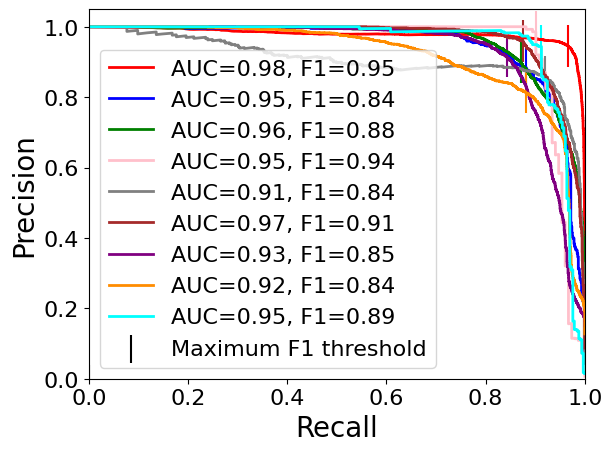

In [ ]:
plt.figure()
plt.style.use('default')
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams['font.size'] = 16

# Plot linewidth.
lw = 2
## n_classes -1 is to remove the unknown class
n_classes = len(label_binarizer.classes_)-1

# make prediction on testX for plotting
predY = preds
testY = efamY

fscores = f1_score(efamY.argmax(axis=1), preds.argmax(axis=1), average=None)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
precision = dict()
recall = dict()
roc_auc = dict()
roc_auprc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(testY[:, i], predY[:, i])
    precision[i], recall[i], _ = precision_recall_curve(testY[:, i], predY[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    roc_auprc[i] = auc(recall[i], precision[i])



for i in range(n_classes):
    color = phrog_palette[label_binarizer.classes_[i]]
    fscore = (2 * precision[i] * recall[i]) / (precision[i] + recall[i]) # locate the index of the largest f score
    ix = np.nanargmax(fscore)
    plt.scatter(recall[i][ix], precision[i][ix], marker='|', color=color, s=30**2)
    plt.plot(recall[i], precision[i], color=color, lw=lw,
             label='AUC={0:0.2f}, F1={1:0.2f}'
             ''.format(roc_auprc[i], fscores[i]))



plt.scatter(x=0, y=0, marker='|', color='black', s=20**2, label='Maximum F1 threshold')


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=20)
plt.ylabel('Precision', fontsize=20)

plt.legend(loc="lower left")
plt.savefig('performance_efam_validation_AUPRC.png', dpi=300, bbox_inches='tight')
plt.show()

plt.clf()
plt.cla()
plt.close()



# supplemental figure 4

Best Threshold DNA, RNA and nucleotide metabolism= 0.235619, F-Score=0.956,  FDR=0.054
Best Threshold connector= 0.073006, F-Score=0.883,  FDR=0.115
Best Threshold head and packaging= 0.318375, F-Score=0.886,  FDR=0.099
Best Threshold integration and excision= 0.068280, F-Score=0.942,  FDR=0.014
Best Threshold lysis= 0.098599, F-Score=0.888,  FDR=0.142
Best Threshold moron, auxiliary metabolic gene and host takeover= 0.293297, F-Score=0.915,  FDR=0.040
Best Threshold other= 0.118214, F-Score=0.877,  FDR=0.084
Best Threshold tail= 0.268560, F-Score=0.847,  FDR=0.185
Best Threshold transcription regulation= 0.230482, F-Score=0.928,  FDR=0.056


<ipython-input-6-371d70eb3f4d>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  f_fdr_df = pd.concat([f_fdr_df, df])


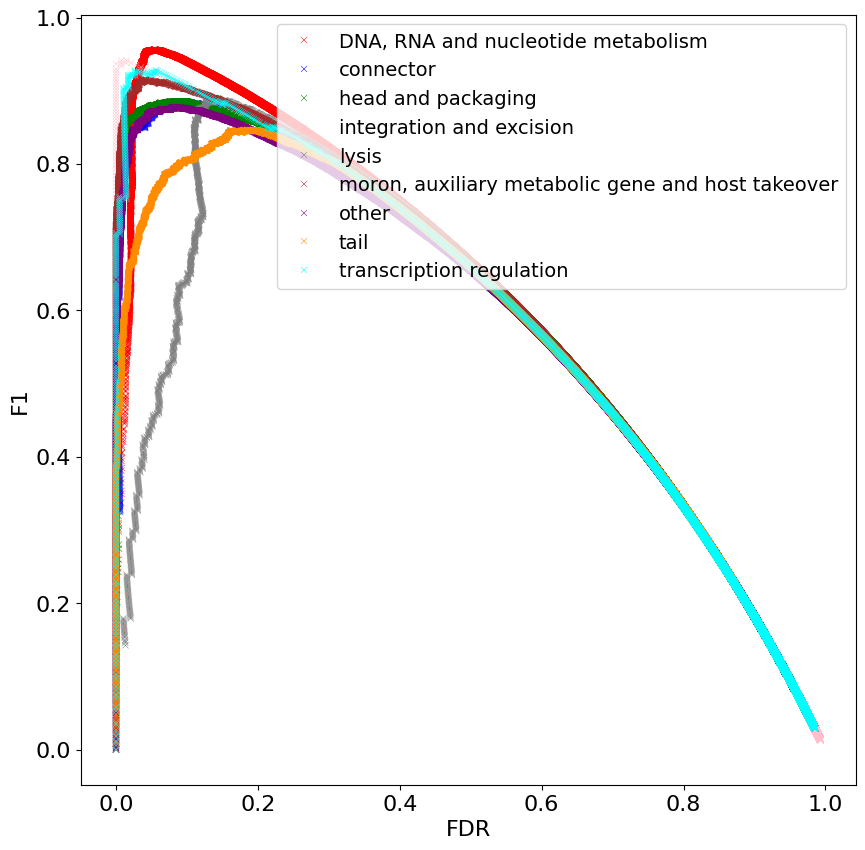

In [ ]:
plt.figure()
sns.reset_defaults()
plt.rcParams["figure.figsize"] = (16,16)
plt.rcParams['font.size'] = 16

## threshold based on F1 score
decision_threshold = {}
thresholded_fscores = []
fdr_rates = {}
f_fdr_df = pd.DataFrame(columns=['fscore', 'fdr', 'class'])
for i in range(len(label_binarizer.classes_)-1):
    precision, recall, thresholds = precision_recall_curve(testY[:, i], predY[:, i])
    fscore = (2 * precision * recall) / (precision + recall)
    fdr = 1 - precision
    ix = np.nanargmax(fscore)
    print('Best Threshold %s= %f, F-Score=%.3f,  FDR=%.3f' % (label_binarizer.classes_[i], thresholds[ix], fscore[ix], fdr[ix]))
    decision_threshold[label_binarizer.classes_[i]] = thresholds[ix]
    thresholded_fscores.append(fscore[ix])
    category = [label_binarizer.classes_[i]] * len(fscore)
    df = pd.DataFrame({'fscore': fscore, 'fdr':fdr, 'class': category})
    f_fdr_df = pd.concat([f_fdr_df, df])


sns.scatterplot(data=f_fdr_df, x='fdr', y='fscore', hue='class', palette=phrog_palette, marker='x', s=20)
plt.xlabel('FDR')
plt.ylabel('F1')
plt.legend(loc='upper right', fontsize=14)
plt.savefig('F1_by_FDR_model_plot.png', dpi=300)
plt.show()


plt.clf()
plt.cla()
plt.close()



# supplemental table 4

Traceback (most recent call last):
  File "<stdin>", line 8, in <module>
IndexError: index 6 is out of bounds for axis 0 with size 6

In [ ]:
FDR = 0.10
# threshold based on F1 score

decision_threshold = {}
thresholded_fscores = []
for i in range(len(label_binarizer.classes_)-1):
    precision, recall, thresholds = precision_recall_curve(testY[:, i], predY[:, i])
    fscore = (2 * precision * recall) / (precision + recall)
    fdr = 1 - precision
    fdr_threshold = fdr < FDR
    ix = np.where(fdr_threshold)[0][np.nanargmax(fscore[np.where(fdr_threshold)])]
    print('Best Threshold %s= %.2f, F-Score=%.2f,  FDR=%.2f, Precision=%.2f, Recall=%.2f' % (label_binarizer.classes_[i], thresholds[ix], fscore[ix], fdr[ix], precision[ix], recall[ix]))
    decision_threshold[label_binarizer.classes_[i]] = thresholds[ix]
    thresholded_fscores.append(fscore[ix])

print('Weighted F1 for calibrated decision boundaries: {0}' ''.format(sum([a*b for a,b in zip(supports,thresholded_fscores)]) / sum(supports)))


Best Threshold DNA, RNA and nucleotide metabolism= 0.24, F-Score=0.96,  FDR=0.05, Precision=0.95, Recall=0.97
Best Threshold connector= 0.12, F-Score=0.88,  FDR=0.09, Precision=0.91, Recall=0.85
Best Threshold head and packaging= 0.32, F-Score=0.89,  FDR=0.10, Precision=0.90, Recall=0.87
Best Threshold integration and excision= 0.07, F-Score=0.94,  FDR=0.01, Precision=0.99, Recall=0.90
Best Threshold lysis= 1.00, F-Score=0.64,  FDR=0.10, Precision=0.90, Recall=0.50
Best Threshold moron, auxiliary metabolic gene and host takeover= 0.29, F-Score=0.92,  FDR=0.04, Precision=0.96, Recall=0.88
Best Threshold other= 0.12, F-Score=0.88,  FDR=0.08, Precision=0.92, Recall=0.84
Best Threshold tail= 0.83, F-Score=0.81,  FDR=0.10, Precision=0.90, Recall=0.73
Best Threshold transcription regulation= 0.23, F-Score=0.93,  FDR=0.06, Precision=0.94, Recall=0.91
Weighted F1 for calibrated decision boundaries: 0.8859079582044209


# supplemental figure 5

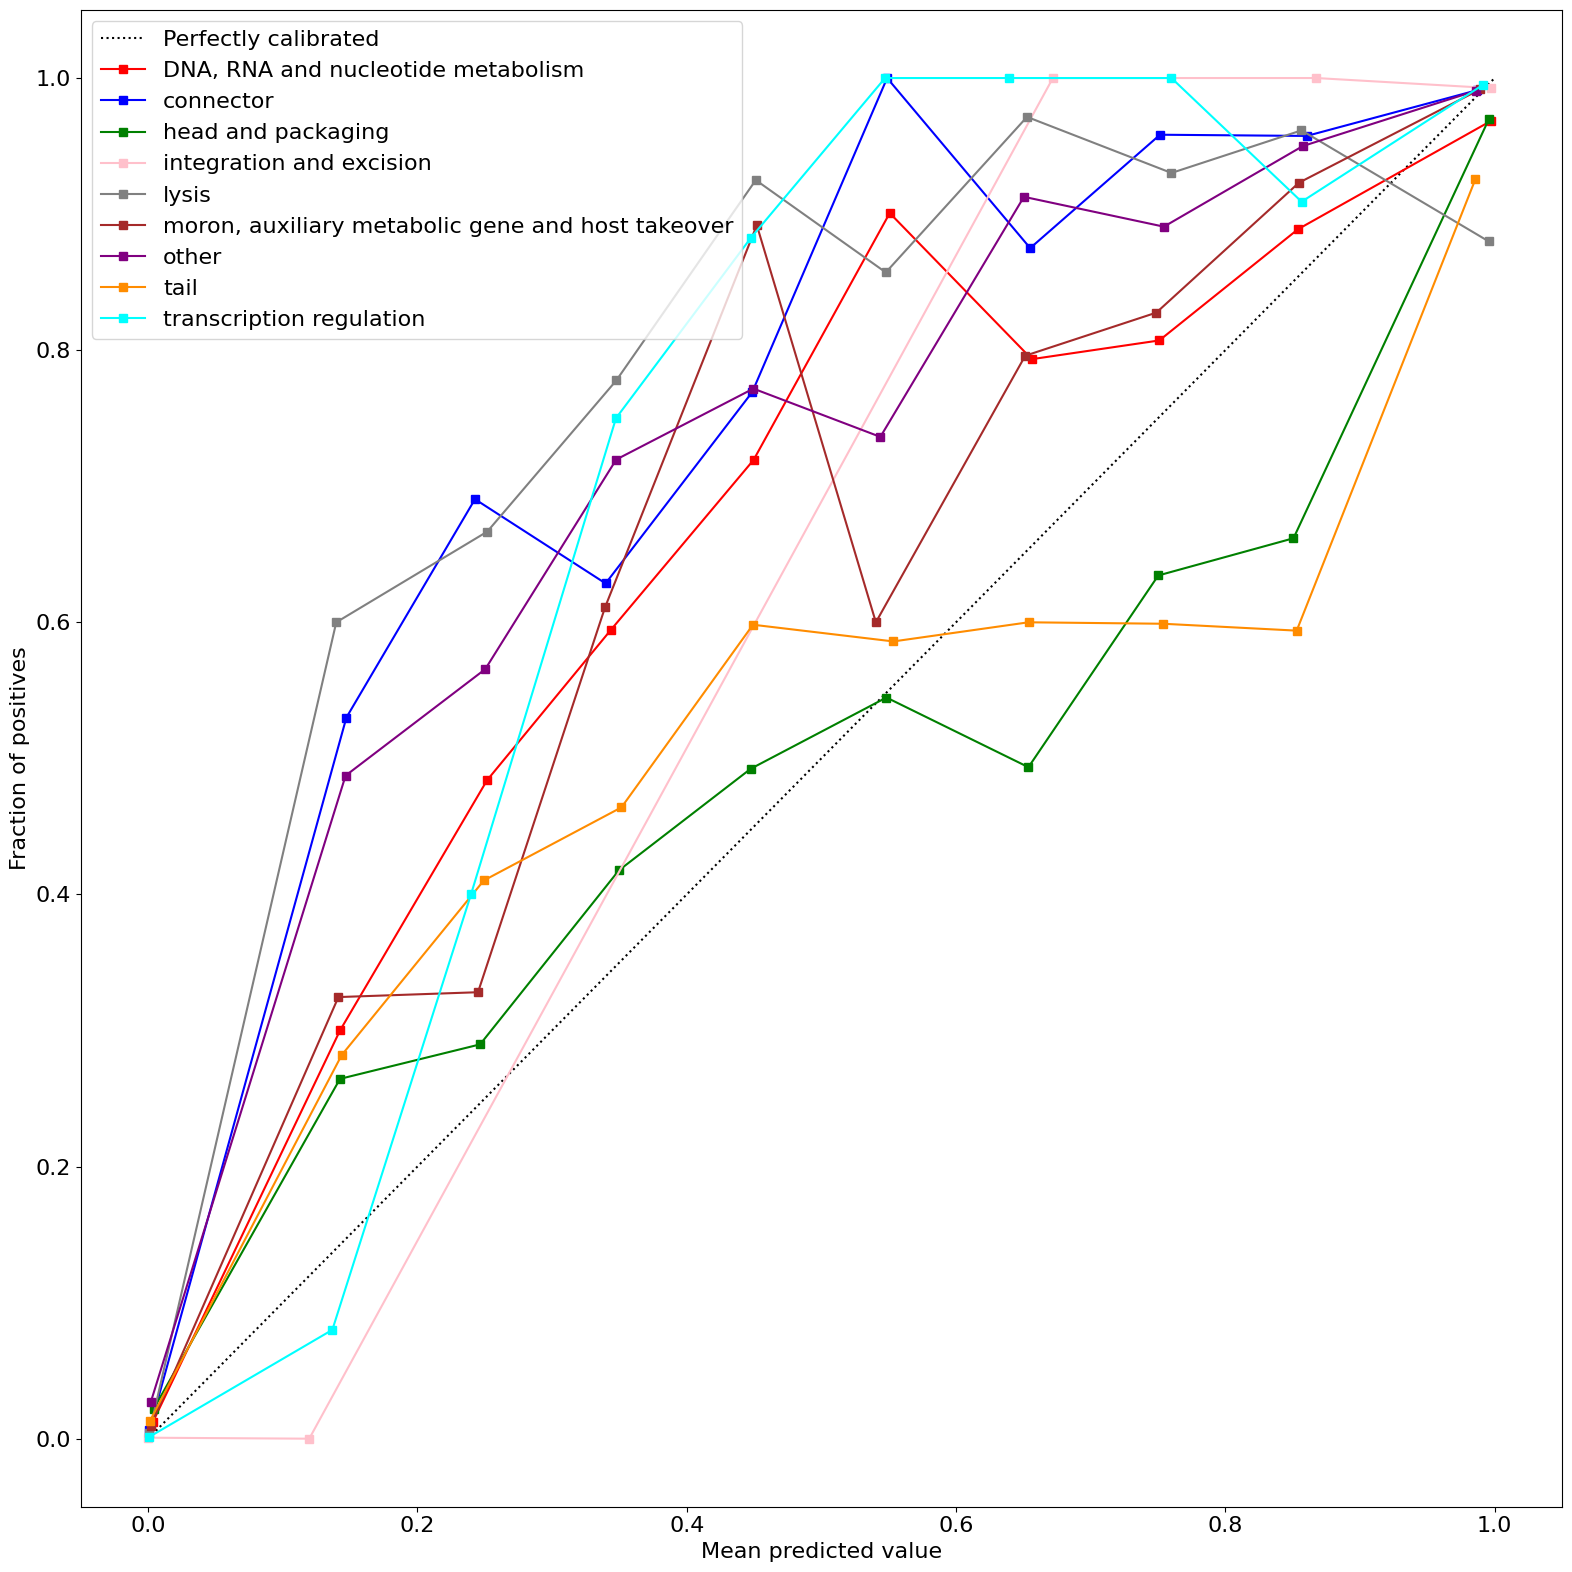

In [ ]:
plt.figure()
plt.style.use('default')
plt.rcParams["figure.figsize"] = (16,16)
plt.rcParams['font.size'] = 16

from sklearn.calibration import calibration_curve


# def plot_calibration_curve(name, fig_index, ytest, probs):
#     """Plot calibration curve for est w/o and with calibration. """


plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

for i in range(len(label_binarizer.classes_)-1):
    name = label_binarizer.classes_[i]
    ytest = testY[:,i]
    probs = predY[:, i]

    frac_of_pos, mean_pred_value = calibration_curve(ytest, probs, n_bins=10)

    plt.plot(mean_pred_value, frac_of_pos, "s-", label=f'{name}', color=phrog_palette[name])


plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
plt.ylim([-0.05, 1.05])
plt.legend(loc="upper left")
#ax1.legend.remove()
#plt.set_title(f'Calibration plot ({name})')

plt.tight_layout()
plt.savefig('calibration_plot_analysis_07072023.png', dpi=300)
plt.show()


plt.clf()
plt.cla()
plt.close()



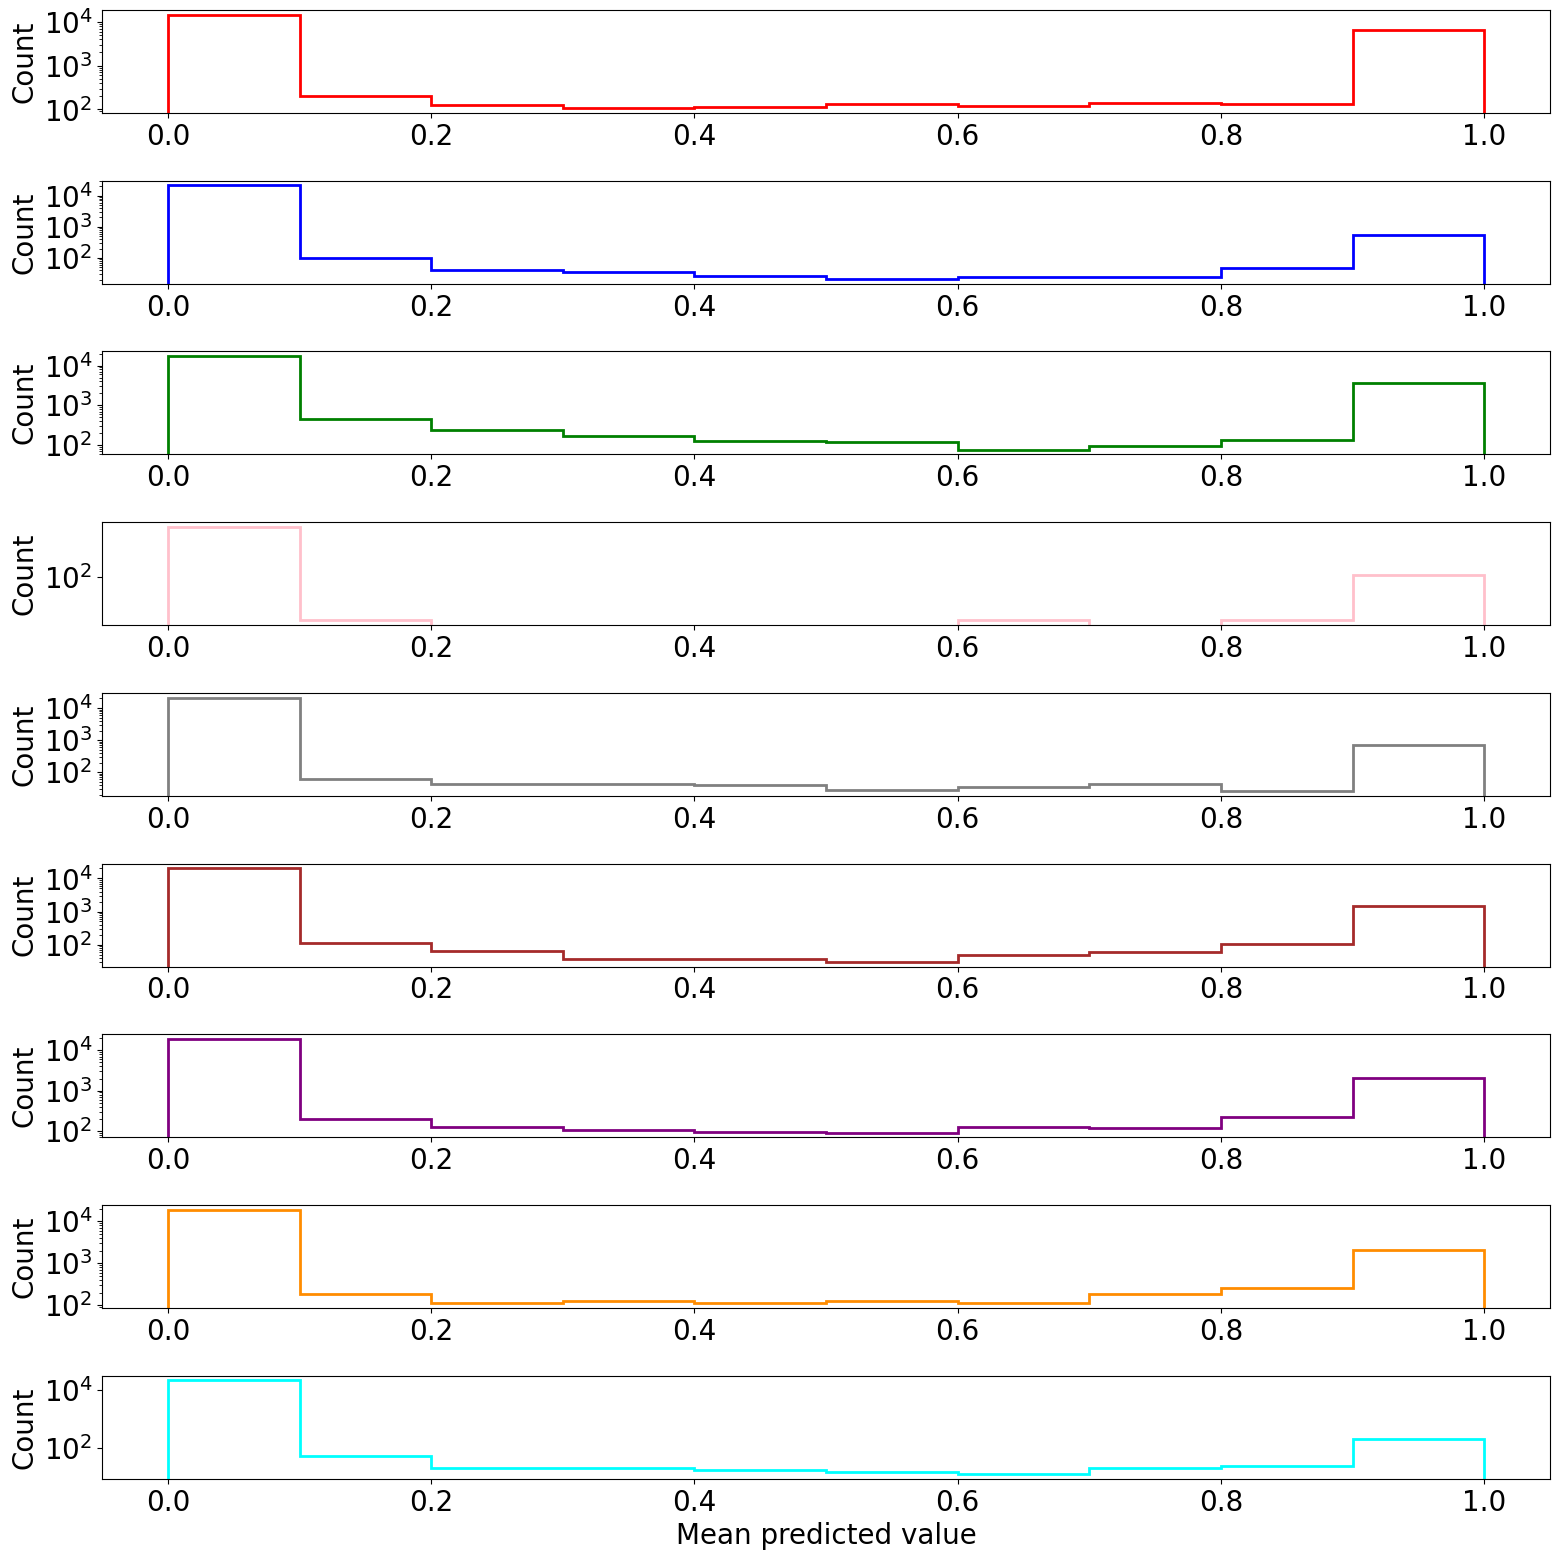

In [ ]:
plt.figure()

plt.style.use('default')
plt.rcParams["figure.figsize"] = (16,10)
plt.rcParams['font.size'] = 20

from sklearn.calibration import calibration_curve


# def plot_calibration_curve(name, fig_index, ytest, probs):
#     """Plot calibration curve for est w/o and with calibration. """



fig = plt.figure(1, figsize=(10, 20))


for i in range(len(label_binarizer.classes_)-1):
    name = label_binarizer.classes_[i]
    ytest = testY[:,i]
    probs = predY[:, i]

    frac_of_pos, mean_pred_value = calibration_curve(ytest, probs, n_bins=10)


    ax = plt.subplot2grid((len(label_binarizer.classes_)-1, 1), (i, 0))
    ax.hist(probs, range=(0, 1), bins=10, label=name, histtype="step", lw=2, color=phrog_palette[name])
    ax.set_ylabel("Count")
    ax.set_yscale('log')

ax.set_xlabel("Mean predicted value")


#ax1.legend.remove()
#ax1.set_title(f'Calibration plot ({name})')

plt.tight_layout()
plt.savefig('calibration_plot_analysis_hists_07072023.png', dpi=300)
plt.show()


plt.clf()
plt.cla()
plt.close()



# figure 4b

<ipython-input-10-50b5ed0e530c>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(x='counts', y='category', palette=phrog_palette, data=threshold_df_no_unknown)
<ipython-input-10-50b5ed0e530c>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(textwrap.fill(x.get_text(), max_width) for x in g.get_yticklabels())


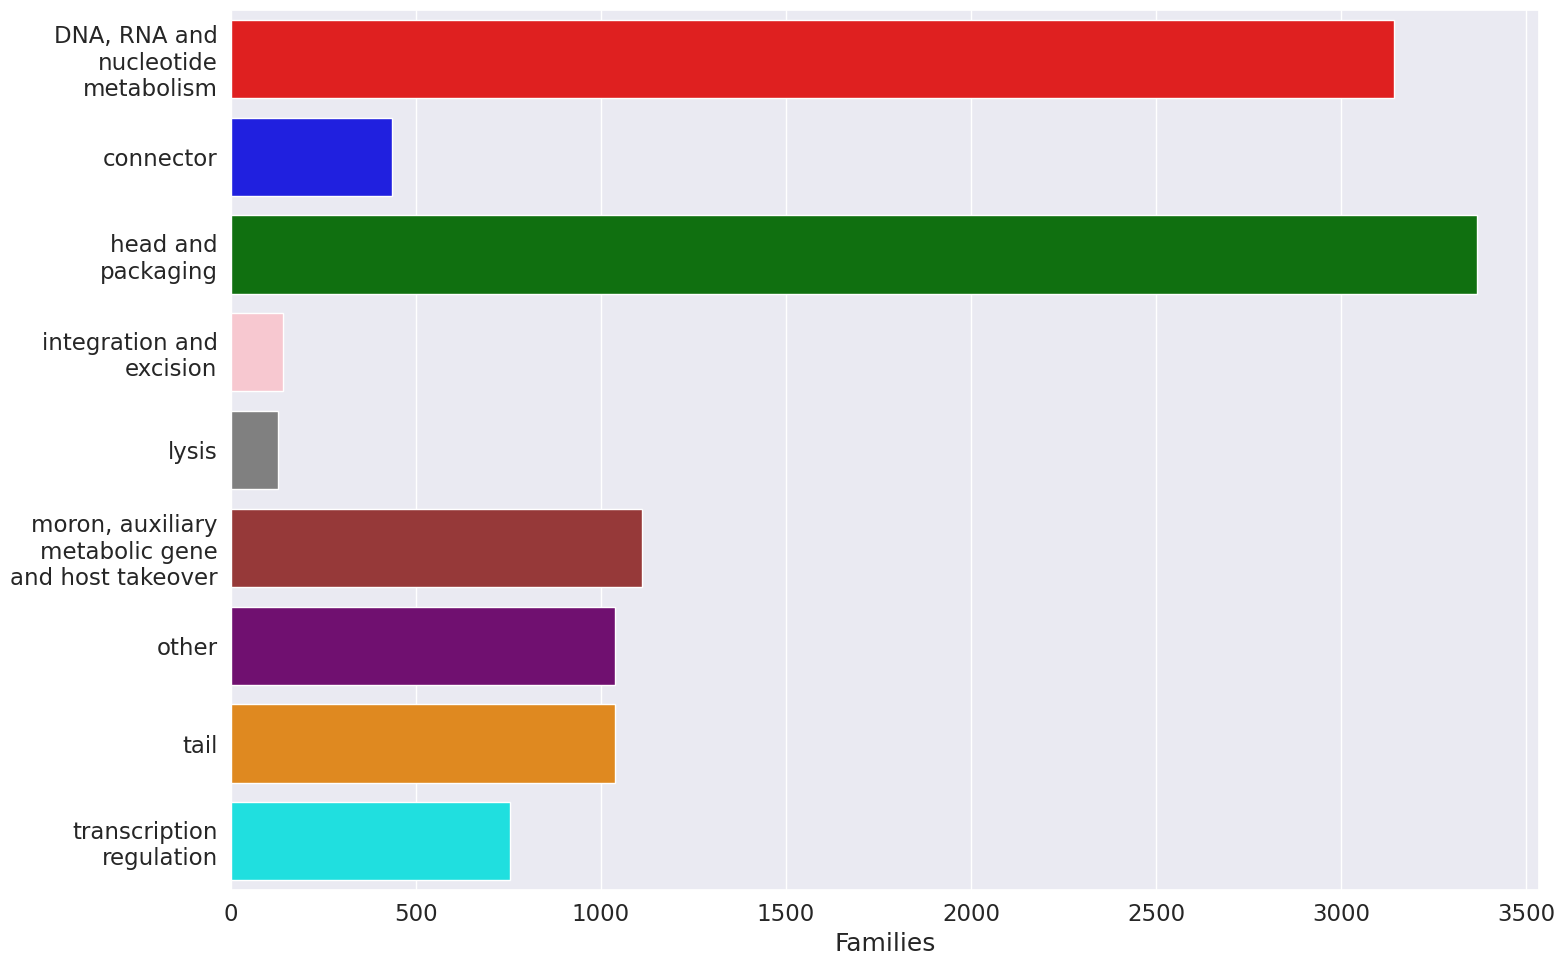

Number of newly annotated EFAM VPFs: 7034
Total EFAM VPFs annotated prior: 28223
% annotation gain: 0.24922935194699358


In [ ]:
cs_assignment = pd.read_csv('efam_clusters_predictions.tsv', sep='\t')
phrog_predicted_clusters_dict = lb
cs_assignment_minus_phrogs = cs_assignment[~cs_assignment['cluster'].isin(phrog_predicted_clusters_dict.keys())]
counts = []
for i in range(len(label_binarizer.classes_)-1):
    label_df = cs_assignment_minus_phrogs[cs_assignment_minus_phrogs['label'] == label_binarizer.classes_[i]]
    #print(decision_threshold[label_binarizer.classes_[i]])
    label_df = label_df[label_df['average_prob'] > decision_threshold[label_binarizer.classes_[i]]]
    counts.append(len(label_df))

threshold_df = pd.DataFrame({'category': list(label_binarizer.classes_)[0:-1], 'counts': counts})

plt.figure()
plt.rcParams["figure.figsize"]=12,8
sns.set(font_scale=1.5)
max_width=17

threshold_df_no_unknown = threshold_df[threshold_df['category'] != 'unknown']
g = sns.barplot(x='counts', y='category', palette=phrog_palette, data=threshold_df_no_unknown)

g.set_xlabel('Families')
g.set_ylabel('')
g.set_yticklabels(textwrap.fill(x.get_text(), max_width) for x in g.get_yticklabels())

plt.tight_layout()
plt.savefig('efam_clusters_not_PHROG_thresholded_to_max_f1_02212023', dpi=300, bbox_inches='tight')
plt.show()

efam_super_annote['cluster'] = efam_super_annote.index

efam_db_with_predictions_not_phrog_hit = cs_assignment_minus_phrogs.join(efam_super_annote.set_index('cluster'), on='cluster', how='left')
efam_db_with_predictions_not_phrog_hit_unannotated = efam_db_with_predictions_not_phrog_hit[efam_db_with_predictions_not_phrog_hit['Annotation Status'] == 'Unannotated']

counts = []
for i in range(len(label_binarizer.classes_)-1):
    label_df = efam_db_with_predictions_not_phrog_hit_unannotated[efam_db_with_predictions_not_phrog_hit_unannotated['label'] == label_binarizer.classes_[i]]
    label_df = label_df[label_df['average_prob'] > decision_threshold[label_binarizer.classes_[i]]]
    counts.append(len(label_df))

threshold_further_df = pd.DataFrame({'category': list(label_binarizer.classes_)[0:-1], 'counts': counts})

print('Number of newly annotated EFAM VPFs: {0}' ''.format(sum(threshold_further_df['counts'][:-1])))

print('Total EFAM VPFs annotated prior: {0}' ''.format(len(cs_assignment) - len(efam_db_with_predictions_not_phrog_hit_unannotated)))

new_frac = sum(threshold_further_df['counts'][:-1]) / (len(cs_assignment) - len(efam_db_with_predictions_not_phrog_hit_unannotated))
print('% annotation gain: {0}' ''.format(new_frac))


plt.clf()
plt.cla()
plt.close()



# figure 4c

<ipython-input-11-03c9b69c5024>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Family {0} probability' ''.format(category)] = df['average_prob']
<ipython-input-11-03c9b69c5024>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Family average protein length'] = df['average_protein_length']
<ipython-input-11-03c9b69c5024>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

<Figure size 1200x800 with 0 Axes>

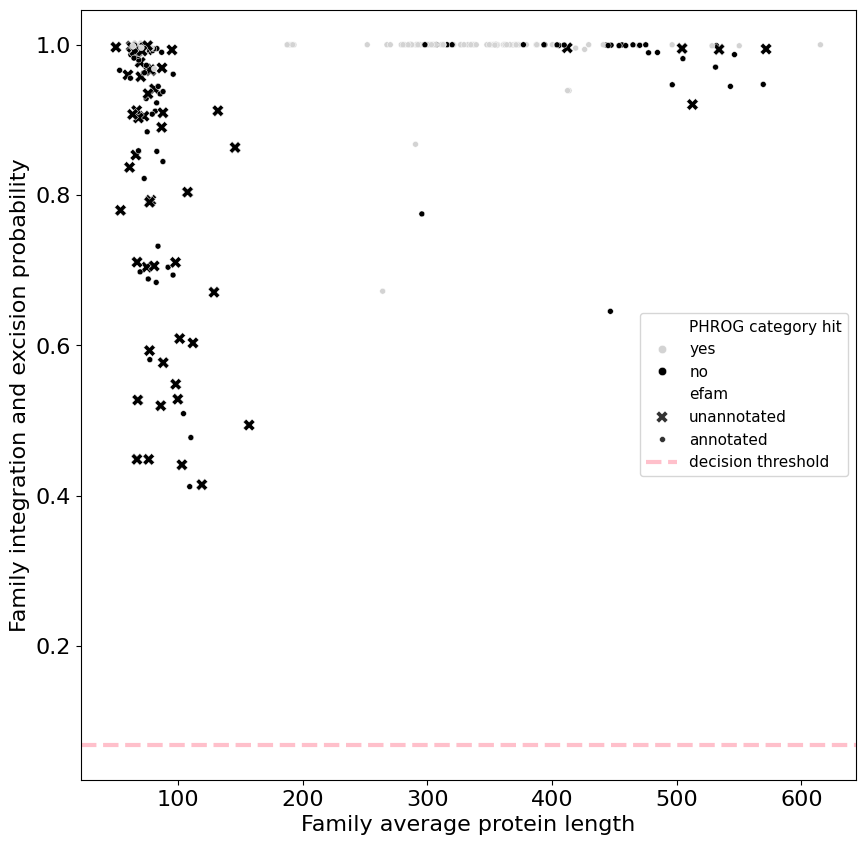

In [ ]:
category = 'integration and excision'

clusters_with_integration_hhsearch_hit = [k for k,v in lb.items() if v[0] == category]

integration_excision_efam_followup = cs_assignment[(cs_assignment['cluster'].isin(clusters_with_integration_hhsearch_hit)) | (cs_assignment['label'] == category)]
integration_excision_efam_followup = integration_excision_efam_followup.join(efam_super_annote.set_index('cluster'), on='cluster', how='left')
integration_excision_efam_followup['decision_threshold'] = [1 if x > decision_threshold[category] else 0 for x in integration_excision_efam_followup['average_prob']]
integration_excision_efam_followup['efam_e_threshold'] = [1 if x in phrog_predicted_clusters_dict.keys() else 0 for x in integration_excision_efam_followup['cluster']]
integration_excision_efam_followup['efam_e_threshold_category'] = [1 if x in clusters_with_integration_hhsearch_hit else 0 for x in integration_excision_efam_followup['cluster']]
## remove the clusters not predicted integration and excision for the purposes of the figure
df = integration_excision_efam_followup
df = df[df['label'] == category]
plt.figure()
plt.style.use('default')
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["font.size"] = 16
plt.rcParams["figure.frameon"] = False

df['Family {0} probability' ''.format(category)] = df['average_prob']
df['Family average protein length'] = df['average_protein_length']
df['PHROG category hit'] = ['yes' if x == 1 else 'no' for x in df['efam_e_threshold_category']]
df['efam'] = ['annotated' if x == 'Annotated' else 'unannotated' for x in df['Annotation Status']]

plt.figure(frameon=False)
g = sns.scatterplot(
    y='Family {0} probability' ''.format(category),
    x='Family average protein length',
    hue='PHROG category hit',
    palette=['lightgray', 'black'],
    hue_order=['yes','no'],
    style='efam',
    size_order=['unannotated', 'annotated'],
    size='efam',
    data=df
)

g.axhline(decision_threshold[category], color='pink', linestyle='--', lw=3, label='decision threshold')
g.legend(fontsize=11)

plt.savefig('efam_integration_excision_threshold.png', dpi=300, )
plt.show()

plt.clf()
plt.cla()
plt.close()




In [ ]:
df_e = df[df['efam_e_threshold_category'] == 0]
df_e_threshold_1 = df_e[df_e['decision_threshold'] == 1]
df_filtered_e_decision_threshold_unnanottated = df_e_threshold_1[df_e_threshold_1['Annotation Status'] == 'Unannotated']

df_e_threshold_1_annotated = df_e_threshold_1[df_e_threshold_1['Annotation Status'] == 'Annotated']
df_e_threshold_1_greater = df_e_threshold_1_annotated[df_e_threshold_1_annotated['average_protein_length'] > 120]
df_e_threshold_1_less = df_e_threshold_1_annotated[df_e_threshold_1_annotated['average_protein_length'] < 120]

a = [ll.split('=')[0].split('\'') for l in list(df_e_threshold_1_greater['Annotation(s) / Hit(s):']) for ll in l.strip().split(';')]
a = [l[1].strip() for l in a if len(l) > 1]
a = [l.lower() for l in a if len(l) > 0]

b = [ll.split('=')[0].split('\'') for l in list(df_e_threshold_1_less['Annotation(s) / Hit(s):']) for ll in l.strip().split(';')]
b = [l[1].strip() for l in b if len(l) > 1]
b = [l.lower() for l in b if len(l) > 0]

a = pd.Series(a)
b = pd.Series(b)

a.value_counts()[a.value_counts() > 10]
b.value_counts()[b.value_counts() > 10]


,count
no annotation found,52
hth_17 domain-containing protein,26
helix-turn-helix domain,26
uncharacterized protein,14


# supplemental table 5

In [ ]:
df_filtered_e_decision_threshold_unnanottated.to_csv('efam_{0}_filtered.csv' ''.format(category), index=False)

In [ ]:

!gsutil -m cp -r F1_by_FDR_model_plot.png gs://plm-model-comparison/EFAM_embed/Esm2/supp_figures_4_5

!gsutil -m cp -r calibration_plot_analysis_07072023.png gs://plm-model-comparison/EFAM_embed/Esm2/supp_figures_4_5

!gsutil -m cp -r calibration_plot_analysis_hists_07072023.png gs://plm-model-comparison/EFAM_embed/Esm2/supp_figures_4_5

!gsutil -m cp -r efam_clusters_not_PHROG_thresholded_to_max_f1_02212023.png gs://plm-model-comparison/EFAM_embed/Esm2/supp_figures_4_5

!gsutil -m cp -r efam_integration\ and\ excision_filtered.csv gs://plm-model-comparison/EFAM_embed/Esm2/supp_figures_4_5

!gsutil -m cp -r efam_integration_excision_threshold.png gs://plm-model-comparison/EFAM_embed/Esm2/supp_figures_4_5

!gsutil -m cp -r performance_efam_validation_AUPRC.png gs://plm-model-comparison/EFAM_embed/Esm2/supp_figures_4_5


Copying file://F1_by_FDR_model_plot.png [Content-Type=image/png]...
/ [1/1 files][658.9 KiB/658.9 KiB] 100% Done                                    
Operation completed over 1 objects/658.9 KiB.                                    
Copying file://calibration_plot_analysis_07072023.png [Content-Type=image/png]...
/ [1/1 files][  1.1 MiB/  1.1 MiB] 100% Done                                    
Operation completed over 1 objects/1.1 MiB.                                      
Copying file://calibration_plot_analysis_hists_07072023.png [Content-Type=image/png]...
/ [1/1 files][417.9 KiB/417.9 KiB] 100% Done                                    
Operation completed over 1 objects/417.9 KiB.                                    
Copying file://efam_clusters_not_PHROG_thresholded_to_max_f1_02212023.png [Content-Type=image/png]...
/ [1/1 files][224.1 KiB/224.1 KiB] 100% Done                                    
Operation completed over 1 objects/224.1 KiB.                                    
Copying 